In [214]:
import pandas as pd
import numpy as np

In [215]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [216]:
csv = pd.read_csv("housing.csv", header=None, delimiter=r"\s+", names=column_names)

In [217]:
data = pd.DataFrame(csv)

**Data Normalization**

In [218]:
data =(data-data.min())/(data.max()-data.min())

In [219]:
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680,0.422222
1,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470,0.368889
2,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466,0.660000
3,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389,0.631111
4,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338,0.693333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.000633,0.00,0.420455,0.0,0.386831,0.580954,0.681771,0.122671,0.000000,0.164122,0.893617,0.987619,0.219095,0.386667
502,0.000438,0.00,0.420455,0.0,0.386831,0.490324,0.760041,0.105293,0.000000,0.164122,0.893617,1.000000,0.202815,0.346667
503,0.000612,0.00,0.420455,0.0,0.386831,0.654340,0.907312,0.094381,0.000000,0.164122,0.893617,1.000000,0.107892,0.420000
504,0.001161,0.00,0.420455,0.0,0.386831,0.619467,0.889804,0.114514,0.000000,0.164122,0.893617,0.991301,0.131071,0.377778


**Train-Test-Validation splitting**

In [220]:
from sklearn.model_selection import train_test_split
x = data.iloc[:, :13].values
y = data.iloc[:, 13:].values 
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.2)

In [242]:
def softmax(z):
    ez = np.exp(z)
    a = ez/np.sum(ez)
    return a

def sigmoid(z):
    return 1/(1+np.exp(-z))

def tanh(x):
    return np.tanh(x)

def leaky_relu(x):
    if x>0:
        return x
    else:
        return 0.01*x

def elu(x):
    if x>0:
        return x
    else:
        return 0.01*(np.exp(x)-1)

def selu(x):
    if x>0:
        return 1.0507*x
    else:
        return 1.0507*1.67326*(np.exp(x)-1)

def softplus(x):
    return np.log(1+np.exp(x))

In [225]:
def dense(feature,numOfNeuron,activation_function = sigmoid):
    den = {'weights': 2*np.random.random((numOfNeuron,feature)) - 1,
            'bias': np.random.rand(numOfNeuron,1),
            '#neurons': numOfNeuron,
            'activation func':activation_function,
            'neuron outputs': []
    }
    return den

In [226]:
def error(actual,pred):
    return ((actual-pred)**2)/2

In [227]:
def sigmoid_derivation(x):
    return sigmoid(x)*(1-sigmoid(x))

In [236]:
#write back propagation for neural network

def vectorize(x,i):
    arr = []
    for _ in range(x.shape[0]):
        arr.append([x[_][i]])
    return np.array(arr)

def forward(layers,input):
    
    pred = None
    curr_outputs = []
    vector = input
    for layer in layers:
        layer['neuron outputs'] = []
        for _ in range(layer['#neurons']):
            curr_outputs.append(layer['activation func'](np.dot(vector,layer['weights'][_]) + layer['bias'][_])[0])
            layer['neuron outputs'].append(curr_outputs[-1])
        vector = curr_outputs
        curr_outputs = []
    pred = vector

    return np.array(pred)

def rmse(layers,x,y):
    import math
    total = 0
    for _ in range(x.shape[0]):
        total+=np.subtract(y[_],forward(layers,x[_]))
    return math.sqrt(np.square(total).mean()/2)


def backprop(layers,x,y):
    pred = forward(layers,x)
    error = np.subtract(y,pred)
    return error

def update(layers,x,y,learning_rate, batch_size = 1):
    size = x.shape[0]-(x.shape[0]%batch_size)
    for _ in range(0,size,batch_size):
        batch = x[_:_+batch_size]
        batch_y = y[_:_+batch_size]
        error = 0
        for row in range(batch_size):
            error += backprop(layers,batch[row],batch_y[row])
        error/=batch_size
        for layer in layers:
            for _ in range(layer['#neurons']):
                layer['weights'][_] = layer['weights'][_] + learning_rate*error*layer['activation func'](layer['neuron outputs'][_])
                layer['bias'][_] = layer['bias'][_] + learning_rate*error*layer['activation func'](layer['neuron outputs'][_])

    return layers


def train(layers,x,y,learning_rate,epochs = 5,batch_size = 1):
    for _ in range(epochs):
        layers = update(layers,x,y,learning_rate,batch_size=batch_size)
        """if _%20 == 0:
            print("EPOCH :",_,"ERROR :",rmse(layers,x,y))"""
    return layers


def predict(layers,x):
    pred = []
    for _ in range(x.shape[0]):
        pred.append(forward(layers,x[_]))
    return pred

**Finding best parameters for neural network which has 1 hidden layer**

In [271]:
test = {
    '#neurons of 1st layer': [1,2,3,5,7],
    'learning rate': [0.01,0.05],
    'batch size': [1,2,3,4,5],
    'epoch': [10,25,50],
    'activation function': [sigmoid,softmax,tanh,softplus]
}

min_error = 1000000
min = {
    '#neurons of 1st layer': None,
    'learning rate': None,
    'batch size': None,
    'epoch': None,
    'activation function': None
}

for i in test['#neurons of 1st layer']:
    for j in test['learning rate']:
        for k in test['batch size']:
            for l in test['epoch']:
                for m in test['activation function']:
                    w1 = dense(13,i,m)
                    output_layer = dense(i,1,activation_function=m)
                    train([w1,output_layer],xtrain,ytrain,j,l,batch_size= k)
                    if(rmse([w1,output_layer],xtrain,ytrain)) < min_error:
                        min['#neurons of 1st layer'] = i
                        min['learning rate'] = j
                        min['batch size'] = k
                        min['epoch'] = l
                        min['activation function'] = m
                        min_error = rmse([w1,output_layer],xtrain,ytrain)

C:\Users\Emre\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Emre\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


**Finding best parameters for neural network which has 2 hidden layer**

In [270]:
test2 = {
    '#neurons of 1st layer': [3,5,7],
    '#neurons of 2nd layer': [3,5,7],
    'learning rate': [0.01,0.05,0.1],
    'batch size': [1,3,5],
    'epoch': [20,30,50],
    'activation function': [sigmoid,softmax,tanh,softplus]
}

min_error2 = 1000000
min2 = {
    '#neurons of 1st layer': None,
    '#neurons of 2nd layer': None,
    'learning rate': None,
    'batch size': None,
    'epoch': None,
    'activation function': None
}

for i in test2['#neurons of 1st layer']:
    for j in test2['#neurons of 2nd layer']:
        for k in test2['learning rate']:
            for l in test2['batch size']:
                for m in test2['epoch']:
                    for n in test2['activation function']:
                        w1 = dense(13,i,n)
                        w2 = dense(i,j,n)
                        output_layer = dense(j,1,activation_function=n)
                        train([w1,w2,output_layer],xtrain,ytrain,k,m,batch_size= l)
                        if(rmse([w1,w2,output_layer],xtrain,ytrain)) < min_error2:
                            min2['#neurons of 1st layer'] = i
                            min2['#neurons of 2nd layer'] = j
                            min2['learning rate'] = k
                            min2['batch size'] = l
                            min2['epoch'] = m
                            min2['activation function'] = n
                            min_error2 = rmse([w1,w2,output_layer],xtrain,ytrain)

C:\Users\Emre\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
C:\Users\Emre\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Emre\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in add
C:\Users\Emre\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in add


**Finding best parameters for neural network which has 0 hidden layer**

In [286]:
test3 = {
    'learning rate': [0.01,0.05,0.1],
    'batch size': [1,2,3,4,5,7,10],
    'epoch': [5,10,20,30,50],
    'activation function': [sigmoid,softmax,tanh,softplus]
}

min_error3 = 1000000
min3 = {
    'learning rate': None,
    'batch size': None,
    'epoch': None,
    'activation function': None
}

for i in test3['learning rate']:
    for j in test3['batch size']:
        for k in test3['epoch']:
            for l in test3['activation function']:
                output_layer = dense(13,1,activation_function=l)
                train([output_layer],xtrain,ytrain,i,k,batch_size= j)
                if(rmse([output_layer],xtrain,ytrain)) < min_error3:
                    min3['learning rate'] = i
                    min3['batch size'] = j
                    min3['epoch'] = k
                    min3['activation function'] = l
                    min_error3 = rmse([output_layer],xtrain,ytrain)

C:\Users\Emre\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [273]:
min #for one hidden layer

{'#neurons of 1st layer': 2,
 'learning rate': 0.01,
 'batch size': 4,
 'epoch': 50,
 'activation function': <function __main__.sigmoid(z)>}

In [274]:
min2 #for two hidden layers

{'#neurons of 1st layer': 7,
 '#neurons of 2nd layer': 3,
 'learning rate': 0.01,
 'batch size': 3,
 'epoch': 50,
 'activation function': <function __main__.sigmoid(z)>}

In [275]:
min3 #for no hidden layers

{'learning rate': 0.001,
 'batch size': 3,
 'epoch': 30,
 'activation function': <function __main__.sigmoid(z)>}

In [359]:
min_error, min_error2, min_error3

(0.018446310608585068, 0.00734952621704263, 0.03629754259831182)

 # Eğitim ve test hatalarının çizdirilmesi

In [318]:
def train_plot(layers,x,y,learning_rate,epochs = 5,batch_size = 1):
    plot_train = {
        'epoch': [],
        'error': []
    }
    plot_test = {
        'epoch': [],
        'error': []
    }
    for _ in range(epochs):
        layers = update(layers,x,y,learning_rate,batch_size=batch_size)
        if _%1 == 0:
            plot_train['epoch'].append(_)
            plot_train['error'].append(rmse(layers,x,y))
            plot_test['epoch'].append(_)
            plot_test['error'].append(rmse(layers,xtest,ytest))            
    return plot_train,plot_test

**For one hidden layer**

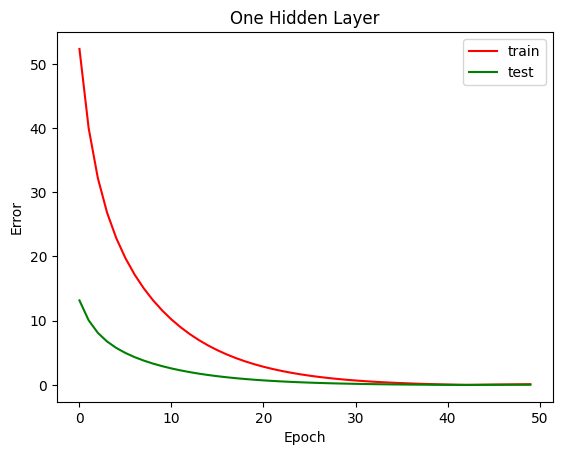

In [346]:
w1 = dense(13,2,activation_function=sigmoid)
output_layer = dense(2,1,activation_function=sigmoid)

one_layer_train,one_layer_test = train_plot([w1,output_layer],xtrain,ytrain,0.01,50,batch_size= 4)

import matplotlib.pyplot as plt
plt.plot(one_layer_train['epoch'], one_layer_train['error'], color='r', label='train')
plt.plot(one_layer_test['epoch'], one_layer_test['error'], color='g', label='test')
  
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("One Hidden Layer")
  
plt.legend()
plt.show()

**For two hidden layer**

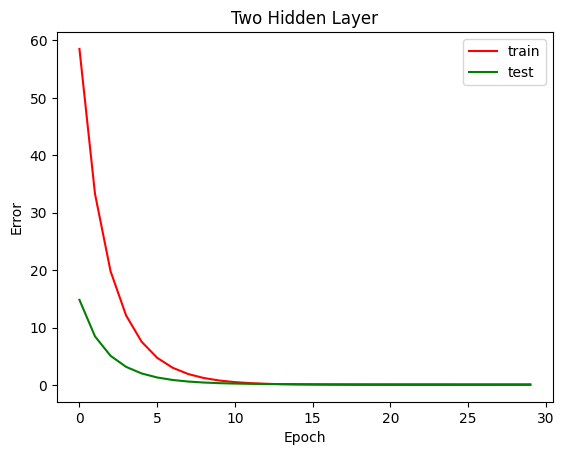

In [345]:
w1 = dense(13,7,activation_function=sigmoid)
w2 = dense(7,3,activation_function=sigmoid)
output_layer = dense(3,1,activation_function=sigmoid)

one_layer_train,one_layer_test = train_plot([w1,w2,output_layer],xtrain,ytrain,0.01,50,batch_size= 3)

plt.plot(one_layer_train['epoch'], one_layer_train['error'], color='r', label='train')
plt.plot(one_layer_test['epoch'], one_layer_test['error'], color='g', label='test')
  
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Two Hidden Layer")
  
plt.legend()
plt.show()

**For zero hidden layer**

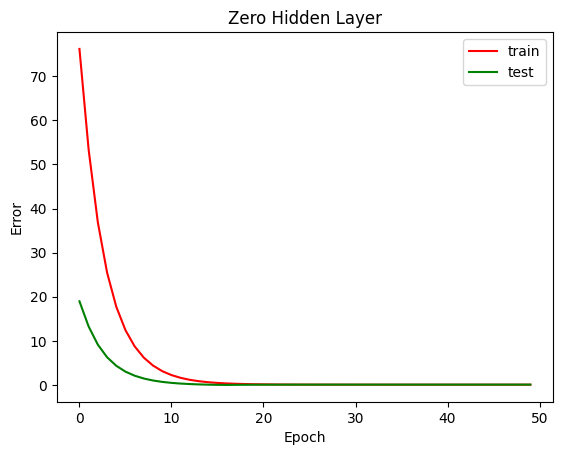

In [349]:
output_layer = dense(13,1,activation_function=sigmoid)

one_layer_train,one_layer_test = train_plot([output_layer],xtrain,ytrain,0.01,50,batch_size= 10)

plt.plot(one_layer_train['epoch'], one_layer_train['error'], color='r', label='train')
plt.plot(one_layer_test['epoch'], one_layer_test['error'], color='g', label='test')
  
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Zero Hidden Layer")
  
plt.legend()
plt.show()

# Farklı neuron sayıları için hata grafikleri

**For one hidden layer**

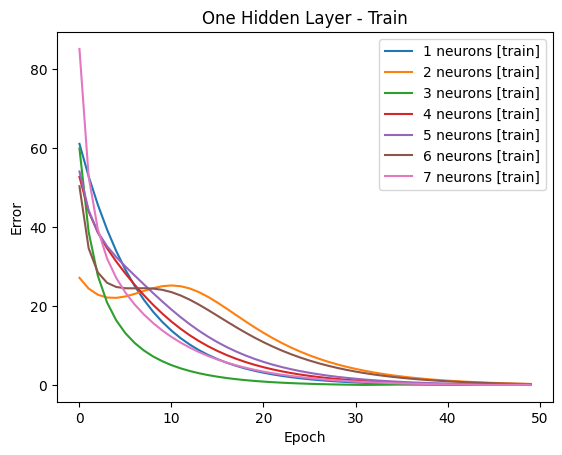

In [325]:
for _ in range(1,8):
    w1 = dense(13,_,activation_function=sigmoid)
    output_layer = dense(_,1,activation_function=sigmoid)
    one_layer_train,one_layer_test = train_plot([w1,output_layer],xtrain,ytrain,0.01,50,batch_size= 4)
    plt.plot(one_layer_train['epoch'], one_layer_train['error'],  label=(str(_)+ ' neurons [train]'))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("One Hidden Layer - Train")
  
plt.legend()
plt.show()

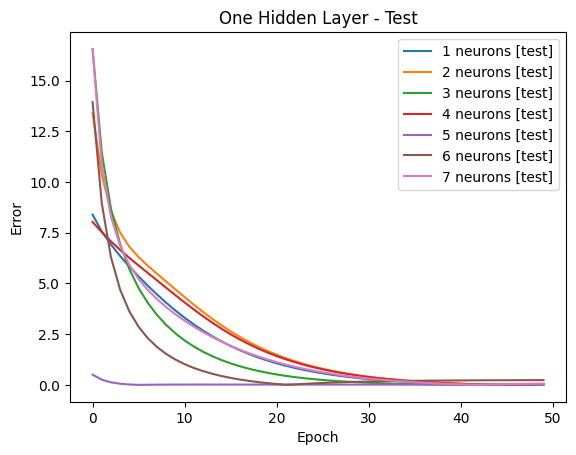

In [326]:
for _ in range(1,8):
    w1 = dense(13,_,activation_function=sigmoid)
    output_layer = dense(_,1,activation_function=sigmoid)
    one_layer_train,one_layer_test = train_plot([w1,output_layer],xtrain,ytrain,0.01,50,batch_size= 4)
    plt.plot(one_layer_test['epoch'], one_layer_test['error'],  label=(str(_)+ ' neurons [test]'))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("One Hidden Layer - Test")
  
plt.legend()
plt.show()

**For two hidden layer**

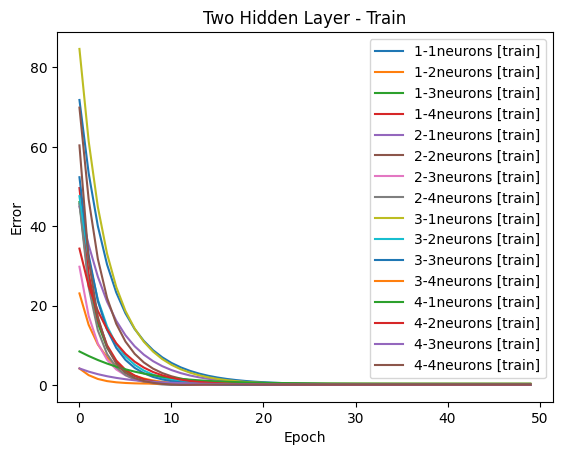

In [327]:
for _ in range(1,5):
    for __ in range(1,5):
        w1 = dense(13,_,activation_function=sigmoid)
        w2 = dense(_,__,activation_function=sigmoid)
        output_layer = dense(__,1,activation_function=sigmoid)
        one_layer_train,one_layer_test = train_plot([w1,w2,output_layer],xtrain,ytrain,0.01,50,batch_size= 3)
        plt.plot(one_layer_train['epoch'], one_layer_train['error'],label=(str(_)+ '-' + str(__) + 'neurons [train]'))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Two Hidden Layer - Train")
  
plt.legend()
plt.show()

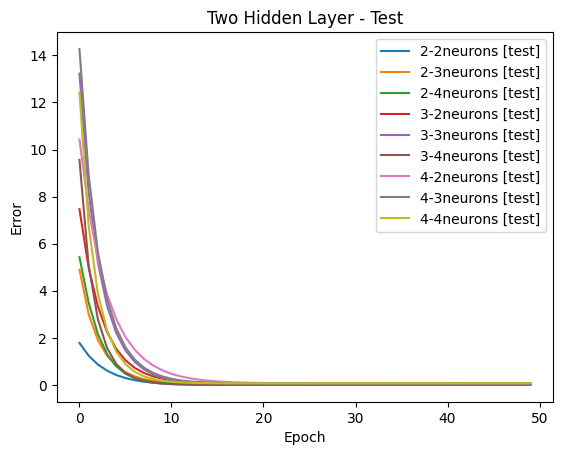

In [328]:
for _ in range(2,5):
    for __ in range(2,5):
        w1 = dense(13,_,activation_function=sigmoid)
        w2 = dense(_,__,activation_function=sigmoid)
        output_layer = dense(__,1,activation_function=sigmoid)
        one_layer_train,one_layer_test = train_plot([w1,w2,output_layer],xtrain,ytrain,0.01,50,batch_size= 3)
        plt.plot(one_layer_test['epoch'], one_layer_test['error'], label=(str(_)+ '-' + str(__) + 'neurons [test]'))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Two Hidden Layer - Test")
  
plt.legend()
plt.show()

# Farkı learning rate'leri için error grafikleri

**For one hidden layer**

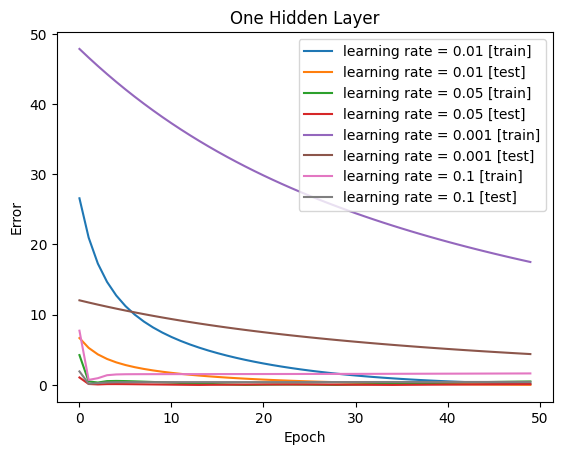

In [329]:
for a in [0.01,0.05,0.001,0.1]:
    w1 = dense(13,2,activation_function=sigmoid)
    output_layer = dense(2,1,activation_function=sigmoid)
    one_layer_train,one_layer_test = train_plot([w1,output_layer],xtrain,ytrain,a,50,batch_size= 4)
    plt.plot(one_layer_train['epoch'], one_layer_train['error'],label=('learning rate = ' + str(a) + ' [train]'))
    plt.plot(one_layer_test['epoch'], one_layer_test['error'],label=(('learning rate = ' + str(a) + ' [test]')))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("One Hidden Layer")
  
plt.legend()
plt.show()

**For two hidden layer**

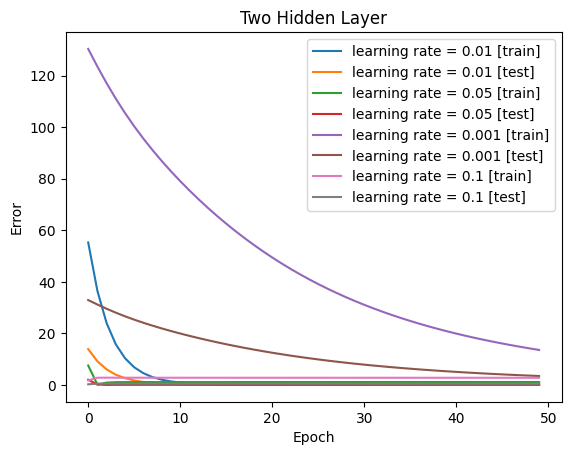

In [330]:
for a in [0.01,0.05,0.001,0.1]:
    w1 = dense(13,7,activation_function=sigmoid)
    w2 = dense(7,3,activation_function=sigmoid)
    output_layer = dense(3,1,activation_function=sigmoid)
    one_layer_train,one_layer_test = train_plot([w1,w2,output_layer],xtrain,ytrain,a,50,batch_size= 3)
    plt.plot(one_layer_train['epoch'], one_layer_train['error'],label=('learning rate = ' + str(a) + ' [train]'))
    plt.plot(one_layer_test['epoch'], one_layer_test['error'],label=(('learning rate = ' + str(a) + ' [test]')))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Two Hidden Layer")
  
plt.legend()
plt.show()

**For zero hidden layer**

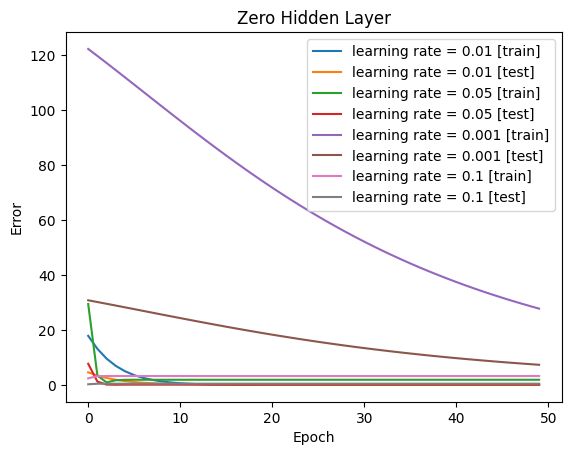

In [354]:
for a in [0.01,0.05,0.001,0.1]:
    output_layer = dense(13,1,activation_function=sigmoid)
    one_layer_train,one_layer_test = train_plot([output_layer],xtrain,ytrain,a,50,batch_size= 10)
    plt.plot(one_layer_train['epoch'], one_layer_train['error'],label=('learning rate = ' + str(a) + ' [train]'))
    plt.plot(one_layer_test['epoch'], one_layer_test['error'],label=(('learning rate = ' + str(a) + ' [test]')))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Zero Hidden Layer")
  
plt.legend()
plt.show()

# Farklı epoch miktarlarıyla hata raporlarının çizdirilmesi

**For one hidden layer**

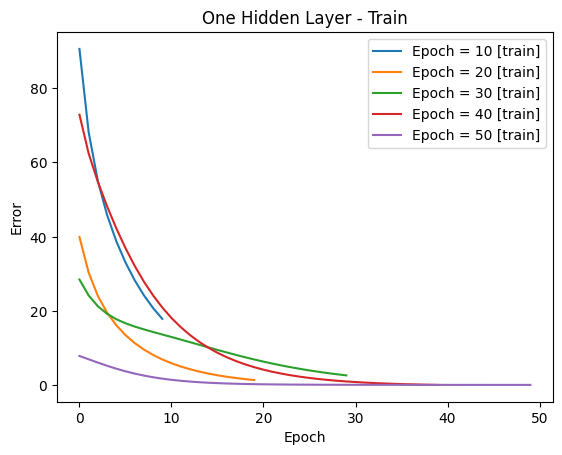

In [334]:
for a in range(10,60,10):
    w1 = dense(13,2,activation_function=sigmoid)
    output_layer = dense(2,1,activation_function=sigmoid)
    one_layer_train,one_layer_test = train_plot([w1,output_layer],xtrain,ytrain,0.01,a,batch_size= 4)
    plt.plot(one_layer_train['epoch'], one_layer_train['error'],label=('Epoch = ' + str(a) + ' [train]'))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("One Hidden Layer - Train")
  
plt.legend()
plt.show()

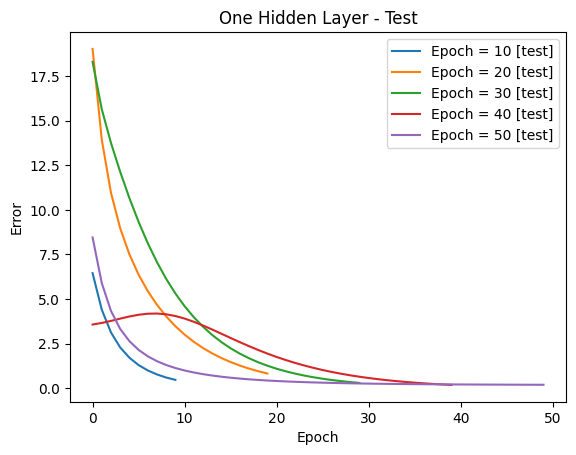

In [335]:
for a in range(10,60,10):
    w1 = dense(13,2,activation_function=sigmoid)
    output_layer = dense(2,1,activation_function=sigmoid)
    one_layer_train,one_layer_test = train_plot([w1,output_layer],xtrain,ytrain,0.01,a,batch_size= 4)
    plt.plot(one_layer_test['epoch'], one_layer_test['error'],label=(('Epoch = ' + str(a) + ' [test]')))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("One Hidden Layer - Test")
  
plt.legend()
plt.show()

**For two hidden layer**

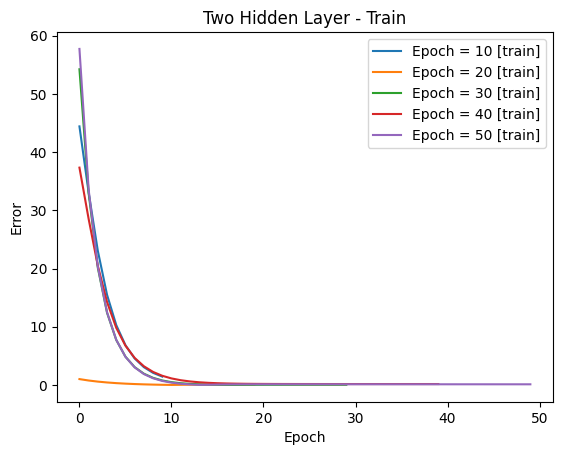

In [355]:
for a in range(10,60,10):
    w1 = dense(13,7,activation_function=sigmoid)
    w2 = dense(7,3,activation_function=sigmoid)
    output_layer = dense(3,1,activation_function=sigmoid)
    one_layer_train,one_layer_test = train_plot([w1,w2,output_layer],xtrain,ytrain,0.01,a,batch_size= 3)
    plt.plot(one_layer_train['epoch'], one_layer_train['error'],label=('Epoch = ' + str(a) + ' [train]'))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Two Hidden Layer - Train")
  
plt.legend()
plt.show()

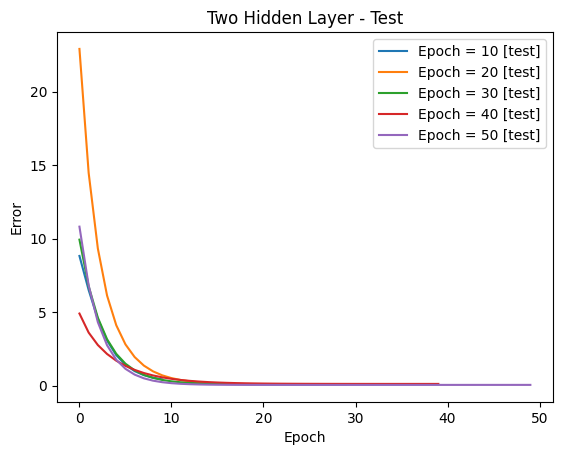

In [356]:
for a in range(10,60,10):
    w1 = dense(13,7,activation_function=sigmoid)
    w2 = dense(7,3,activation_function=sigmoid)
    output_layer = dense(3,1,activation_function=sigmoid)
    one_layer_train,one_layer_test = train_plot([w1,w2,output_layer],xtrain,ytrain,0.01,a,batch_size= 3)
    plt.plot(one_layer_test['epoch'], one_layer_test['error'],label=('Epoch = ' + str(a) + ' [test]'))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Two Hidden Layer - Test")
  
plt.legend()
plt.show()

**For zero hidden layer**

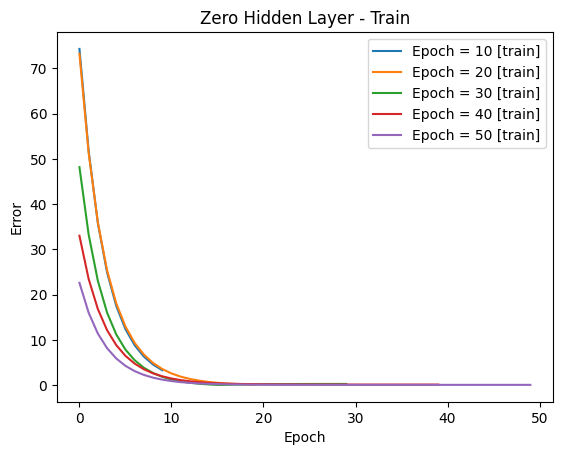

In [357]:
for a in range(10,60,10):
    output_layer = dense(13,1,activation_function=sigmoid)
    one_layer_train,one_layer_test = train_plot([output_layer],xtrain,ytrain,0.01,a,batch_size= 10)
    plt.plot(one_layer_train['epoch'], one_layer_train['error'],label=('Epoch = ' + str(a) + ' [train]'))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Zero Hidden Layer - Train")
  
plt.legend()
plt.show()

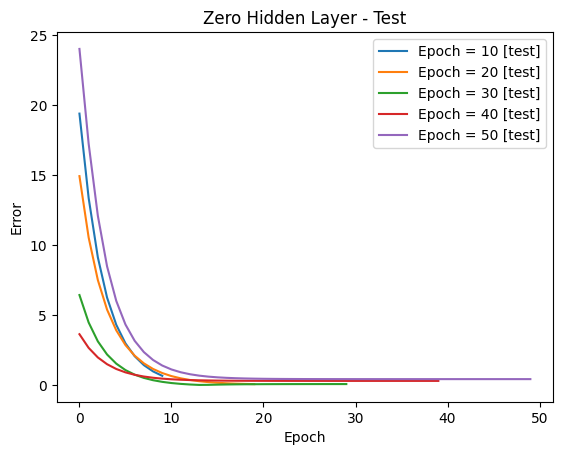

In [358]:
for a in range(10,60,10):
    output_layer = dense(13,1,activation_function=sigmoid)
    one_layer_train,one_layer_test = train_plot([output_layer],xtrain,ytrain,0.01,a,batch_size= 10)
    plt.plot(one_layer_test['epoch'], one_layer_test['error'],label=('Epoch = ' + str(a) + ' [test]'))

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Zero Hidden Layer - Test")
  
plt.legend()
plt.show()